In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torchvision import transforms
from torchinfo import summary
from going_modular.going_modular import data_setup, engine
from helper_functions import download_data, plot_loss_curves
from pathlib import Path

In [3]:
# set model to MPS if available, or GPU, otherwise default to CPU
if torch.backends.mps.is_available():
    device = "mps"
    print ("MPS device found.")
elif torch.cuda.is_available():
    device = "cuda"
    print("GPU found")
else:
    device = "cpu"
    print ("Neither MPS device nor GPU found.")
    
device = "cpu"

MPS device found.


In [5]:
# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"
print(image_path)

# Setup directories
train_dir = image_path / "train"
test_dir = image_path / "test"

data/pizza_steak_sushi


In Table 3, the training resolution is mentioned as being 224 (height=224, width=224). 

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-image-size-and-batch-size.png" width=900 alt="Table 3 from the Vision Transformer paper showing the image size and batch size"/>

In [7]:
IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

The ViT paper states the use of a batch size of 4096 which is 128x the size of the batch size we've been using (32).

However, we're going to stick with a batch size of 16 bc of hardware constraints

In [8]:
BATCH_SIZE = 16

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x16fdf4e90>,
 ['pizza', 'steak', 'sushi'])

In [9]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

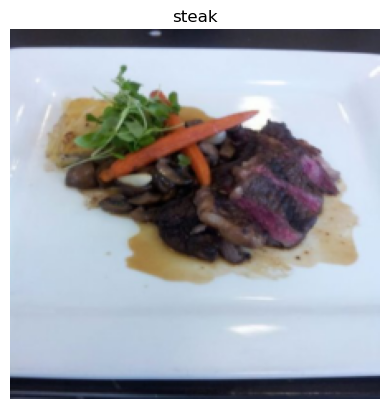

In [42]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

We'll start with the **patch embedding**.

This means we'll be turning our input images in a sequence of patches and then embedding those patches.

We'll begin by following the opening paragraph of section 3.1 of the ViT paper (bold mine):

> The standard Transformer receives as input a 1D sequence of token embeddings. To handle 2D images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches $\mathbf{x}_{p} \in \mathbb{R}^{N \times\left(P^{2} \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^{2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the **patch embeddings**.

In [43]:
# Create example values
height = 224 # H ("The training resolution is 224.")
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


In [44]:
# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


## let's turn a single image into patches

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


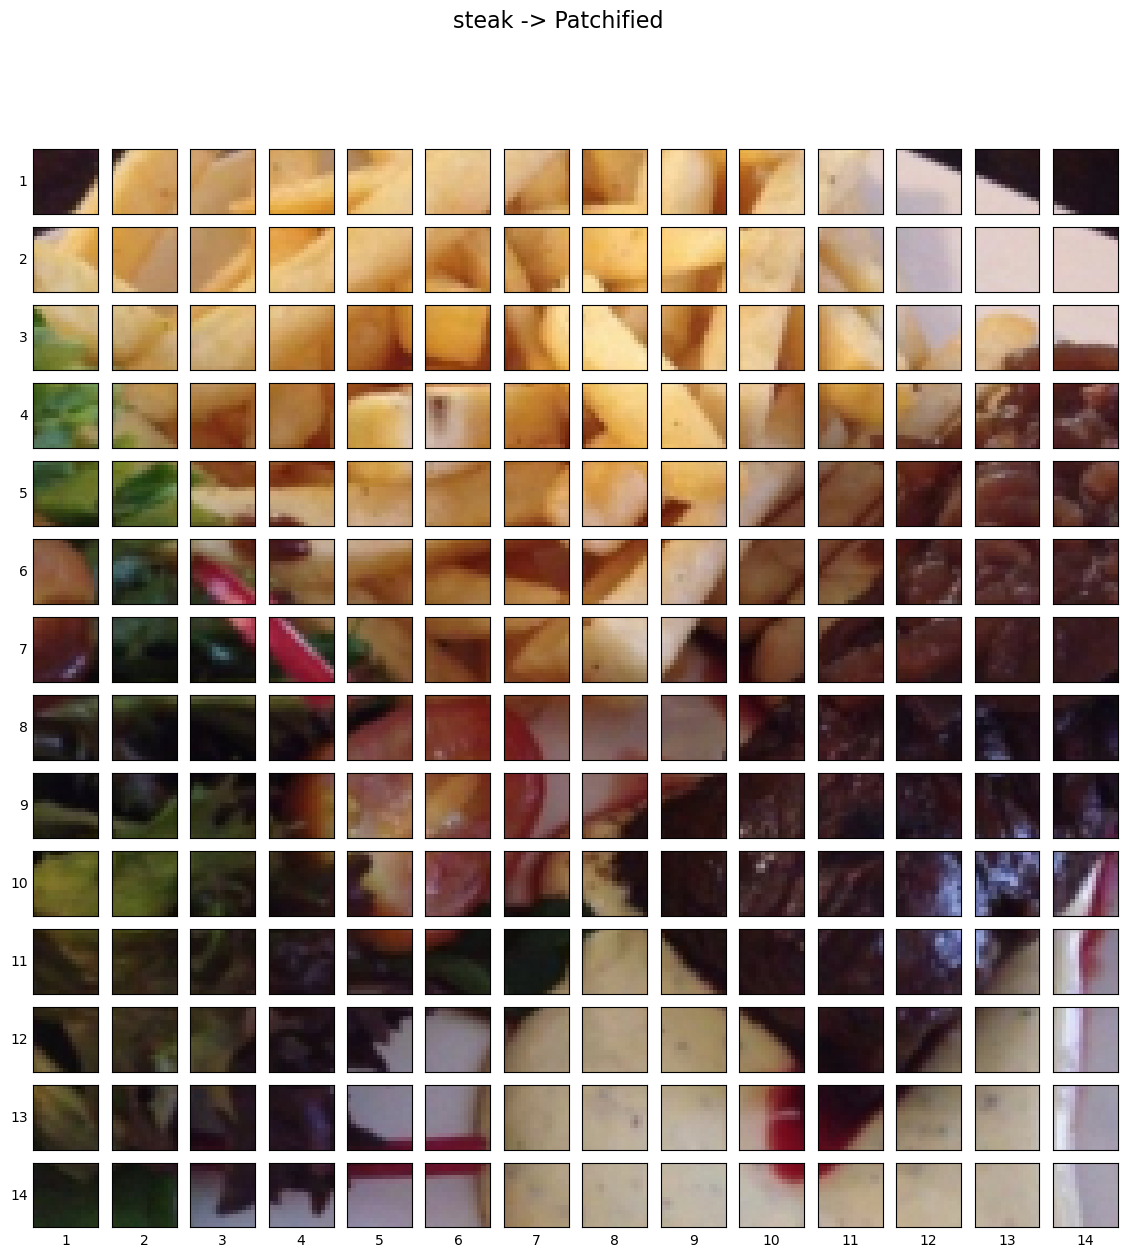

In [45]:
img_permuted = image.permute(1, 2, 0)
img_size = 224
patch_size = 16
num_patches = img_size/patch_size 
assert img_size % patch_size == 0, "Image size must be divisible by patch size" 
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size, 
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width
        
        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height 
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels
        
        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1, 
                             rotation="horizontal", 
                             horizontalalignment="right", 
                             verticalalignment="center") 
        axs[i, j].set_xlabel(j+1) 
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

> **Hybrid Architecture.** As an alternative to raw image patches, the input sequence can be formed from feature maps of a CNN (LeCun et al., 1989). In this hybrid model, the patch embedding projection $\mathbf{E}$ (Eq. 1) is applied to patches extracted from a **CNN feature map**. As a special case, the patches can have spatial size $1 \times 1$, which means that the **input sequence is obtained by simply flattening the spatial dimensions of the feature map and projecting to the Transformer dimension**. The classification input embedding and position embeddings are added as described above.

We can recreate these with:
* [`torch.nn.Conv2d()`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) for turning our image into patches of CNN feature maps.
* [`torch.nn.Flatten()`](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html) for flattening the spatial dimensions of the feature map.

We can replicate the creation of patches by setting the `kernel_size` and `stride` equal to `patch_size`.

We'll set `in_channels=3` for the number of color channels in our image and we'll set `out_channels=768`

In [46]:
conv2d = nn.Conv2d(in_channels=3,
                  out_channels=768,
                  kernel_size=patch_size,
                  stride=patch_size,
                  padding=0)

In [47]:
# Pass the image through the convolutional layer 
# unsqueeze adds a single batch dimension (height, width, color_channels) -> (batch, height, width, color_channels)
image_out_of_conv = conv2d(image.unsqueeze(0)) 
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Showing random convolutional feature maps from indexes: [498, 538, 149, 572, 78]


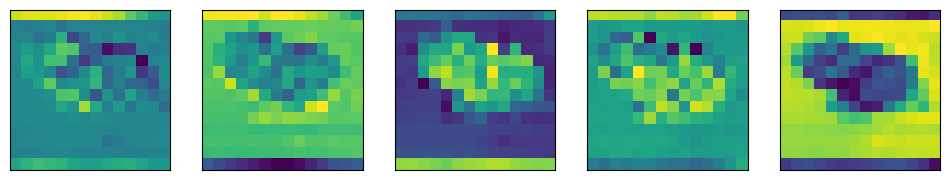

In [49]:
# Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 768), k=5) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [50]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[-0.0359, -0.0481, -0.0517, -0.0420, -0.0449,  0.0103, -0.0429,
           -0.0199,  0.0028,  0.0043,  0.0032,  0.0194,  0.0565,  0.1126],
          [ 0.4381,  0.4393,  0.4462,  0.4559,  0.4264,  0.4506,  0.4511,
            0.4513,  0.4531,  0.4548,  0.4478,  0.4478,  0.4523,  0.4355],
          [ 0.4306,  0.4230,  0.4321,  0.4458,  0.1108,  0.3172,  0.4680,
            0.4522,  0.4243,  0.4373,  0.4436,  0.4492,  0.4342,  0.4339],
          [ 0.4176,  0.3231,  0.1979,  0.1411,  0.0897, -0.0073,  0.0843,
            0.2991,  0.3533,  0.4388,  0.4933,  0.4425,  0.4411,  0.4252],
          [ 0.3846,  0.1668,  0.0610,  0.0732, -0.0353,  0.0471,  0.0160,
            0.2462,  0.0892,  0.1050,  0.2061,  0.4695,  0.4500,  0.4309],
          [ 0.4101,  0.2435,  0.0962,  0.0034,  0.0397,  0.1208,  0.0056,
            0.0071,  0.1280,  0.1243,  0.1565,  0.2374,  0.4764,  0.4326],
          [ 0.4169,  0.3980,  0.2111,  0.1096,  0.0179, -0.0202,  0.0117,
            0.0623,  0.1423,  0.

* **Desired output (1D sequence of flattened 2D patches):** (196, 768) -> (number of patches, embedding dimension) -> ${N \times\left(P^{2} \cdot C\right)}$

Well we've got the 768 part ( $(P^{2} \cdot C)$ ) but we still need the number of patches ($N$).

In [52]:
# Create flatten layer
flatten = nn.Flatten(start_dim=2, # flatten feature_map_height (dimension 2)
                     end_dim=3) # flatten feature_map_width (dimension 3)

In [53]:
# Flatten the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

Flattened image feature map shape: torch.Size([1, 768, 196])


In [54]:
# Get flattened image patch embeddings in right shape 
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


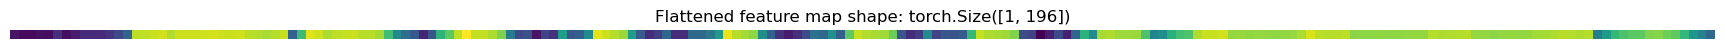

In [55]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

### Turning the ViT patch embedding layer into a PyTorch module

In [58]:
class PatchEmbedding(nn.Module):
    """
    turns a 2d input image into a 1d sequence learnable embedding vec
    """
    def __init__(self,
                in_channels:int=3,
                patch_size:int=16,
                embedding_dim:int=768):
        # \/ this calls the __init__() method of the immediate superclass nn.Module
        super().__init__()
        
        # create layer to turn image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                out_channels=embedding_dim,
                                kernel_size=patch_size,
                                stride=patch_size,
                                padding=0)
        
        # create layer to flatten patch feature maps
        self.flatten = nn.Flatten(start_dim=2,
                                 end_dim=3)
        
    def forward(self, x):
        # check that inputs are correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"
        
        # fwd pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        
        # make sure output shape has right order
        # (b, p^2*c, n) -> (b, n, p^2*c)
        return x_flattened.permute(0,2,1) 

In [59]:
# create instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                         patch_size=16,
                         embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [61]:
# Create random input sizes
random_input_image = (1, 3, 224, 224)
random_input_image_error = (1, 3, 250, 250) # will error because image size is incompatible with patch_size

# Get a summary of the input and outputs of PatchEmbedding (uncomment for full output)
summary(PatchEmbedding(), 
        input_size=random_input_image, # try swapping this for "random_input_image_error" 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

### Creating the class token embedding

> Similar to BERT's `[ class ]` token, we prepend a learnable embedding to the sequence of embedded patches $\left(\mathbf{z}_{0}^{0}=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_{L}^{0}\right)$ serves as the image representation $\mathbf{y}$ (Eq. 4). 

> **Note:** [BERT](https://arxiv.org/abs/1810.04805) (Bidirectional Encoder Representations from Transformers) is one of the original machine learning research papers to use the Transformer architecture to achieve outstanding results on natural language processing (NLP) tasks and is where the idea of having a `[ class ]` token at the start of a sequence originated, class being a description for the "classification" class the sequence belonged to.

So we need to "preprend a learnable embedding to the sequence of embedded patches".

Let's start by viewing our sequence of embedded patches tensor (created in section 4.5) and its shape.

In [63]:
# View the patch embedding and patch embedding shape
print(patch_embedded_image) 
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-0.2034,  0.1484, -0.2563,  ..., -0.1505, -0.3813,  0.0243],
         [-0.2115,  0.1365, -0.2696,  ..., -0.1392, -0.4068,  0.0041],
         [-0.2235,  0.1357, -0.2699,  ..., -0.1326, -0.4053,  0.0093],
         ...,
         [ 0.3290,  0.2131,  0.0220,  ..., -0.2593, -0.2078, -0.2940],
         [ 0.2450,  0.1815,  0.0132,  ..., -0.2022, -0.2364, -0.2844],
         [ 0.1826,  0.1593, -0.0099,  ..., -0.1550, -0.2163, -0.2635]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [65]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

# Create the class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_dimension), # [batch_size, number_of_tokens, embedding_dimension]
                           requires_grad=True) # make sure the embedding is learnable

# Show the first 10 examples of the class_token
print(class_token[:, :, :10])

# Print the class_token shape
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

tensor([[[-0.6114,  0.5615, -0.6192, -0.5616, -0.1132, -2.2359, -1.1845,
          -0.7745, -0.5989, -0.6243]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


Now we've got the class token embedding, let's prepend it to our sequence of image patches, `patch_embedded_image`.

We can do so using [`torch.cat()`](https://pytorch.org/docs/stable/generated/torch.cat.html) and set `dim=1` (so `class_token`'s `number_of_tokens` dimension is preprended to `patch_embedded_image`'s `number_of_patches` dimension).

In [67]:
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                     dim=1)

# Print the sequence of patch embeddings with the prepended class token embedding
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-0.6114,  0.5615, -0.6192,  ..., -1.6215, -0.8331,  2.4596],
         [-0.2034,  0.1484, -0.2563,  ..., -0.1505, -0.3813,  0.0243],
         [-0.2115,  0.1365, -0.2696,  ..., -0.1392, -0.4068,  0.0041],
         ...,
         [ 0.3290,  0.2131,  0.0220,  ..., -0.2593, -0.2078, -0.2940],
         [ 0.2450,  0.1815,  0.0132,  ..., -0.2022, -0.2364, -0.2844],
         [ 0.1826,  0.1593, -0.0099,  ..., -0.1550, -0.2163, -0.2635]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


### Creating the position embedding
$$\mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D}$$

Where: 
* $N=H W / P^{2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer (number of patches).
* $D$ is the size of the **patch embeddings**, different values for $D$ can be found in Table 1 (embedding dimension).


In [70]:
# calc number of patches N
number_of_patches = int((height * width) / patch_size**2)

# get embedding dimension D
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

# create learnable 1d position embedding
# not sure why we're not using alternating sin & cos
position_embedding = nn.Parameter(torch.randn(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                 requires_grad = True)# to make them learnable

# show first 10 and check shape
print(position_embedding[:, :10, :10])
print(f"Position embeddding shape: {position_embedding.shape} -> [batch_size, number_of_patches + 1, embedding_dimension]")

tensor([[[ 0.3359,  1.4554, -0.1695,  1.6314, -0.3133,  0.1056,  0.8706,
           2.4804,  1.3084, -0.4967],
         [-1.2521,  0.1516, -0.2524, -1.7545,  0.2913, -0.2090, -0.3016,
          -1.0616,  0.3965, -0.1482],
         [ 0.0762,  0.3243, -0.1295, -0.6645,  0.3769, -0.5853,  0.1045,
          -0.1608,  0.5289, -0.4978],
         [ 0.1440, -0.9736,  0.1231,  0.4475, -0.0796, -0.8570, -0.4593,
           1.0510,  0.8395, -2.2096],
         [ 0.7744,  2.1391, -1.5934,  0.9163, -2.0534, -1.7487, -0.0443,
           0.9160, -1.3110,  0.1805],
         [-0.7388, -0.0178, -0.9575,  0.9321,  2.0349, -0.4828,  1.7627,
           0.0586, -0.4265,  1.4446],
         [-1.1074,  0.0995,  1.8645,  0.9871, -0.2443, -1.7667, -0.1188,
          -1.2276, -0.7872, -2.1132],
         [-1.1607,  0.1599, -2.1731,  1.1916, -0.0778,  0.3817, -1.5195,
           0.5642,  0.5652,  0.4990],
         [-0.3643, -0.7360, -0.5988, -1.0297,  0.7085, -0.0762, -1.1415,
          -0.6055, -1.4800,  1.8055],
 

In [71]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches + 1, embedding_dimension]")

tensor([[[-0.2755,  2.0169, -0.7888,  ..., -0.7585,  2.1842,  3.4167],
         [-1.4555,  0.3000, -0.5087,  ..., -0.2684, -0.3311, -1.4556],
         [-0.1353,  0.4608, -0.3992,  ...,  0.5256, -0.1619, -0.0717],
         ...,
         [-0.5239, -0.1711, -1.3097,  ..., -0.0249, -0.9818,  1.4095],
         [ 2.0563,  0.3848,  0.3978,  ...,  1.3202, -0.1294, -1.9180],
         [ 0.0988, -0.8582, -1.7643,  ...,  0.4967, -0.3205, -1.1911]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches + 1, embedding_dimension]


> **Note:** We could put both the class token embedding and position embedding into their own layer if we wanted to. But we'll see later on in section 8 how they can be incorporated into the overall ViT architecture's `forward()` method.

## let's put it all together

In [74]:
patch_size=16

print(f"image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                      patch_size=patch_size,
                                      embedding_dim=768)

# pass image thru patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_dimension),
                          requires_grad = True)
print(f"Class token embedding shape: {class_token.shape}")

# prepend
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# create pos embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.randn(1, number_of_patches+1, embedding_dimension),
                                 requires_grad=True)

# add pos embed to patch embedd w class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


# MSA


In [75]:
class MultiheadSelfAttentionBlock(nn.Module):
    def __init__(self,
                embedding_dim:int=768,
                num_heads:int=12,
                attn_dropout:float=0):
        super().__init__()
        
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                   num_heads=num_heads,
                                                   dropout=attn_dropout,
                                                   batch_first=True) # does out batch dim come first?
    
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x,
                                            key=x,
                                            value=x,
                                            # do we need the weights or just the layer outputs?
                                            need_weights=False) 
        # yoooo this is so useful for my recurrent heads idea ^
        
        return attn_output

In [76]:
# let's create an MSA instance & pass through the embeddings from earlier
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768,
                                                            num_heads=12)

patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


In [81]:
class MLPBlock(nn.Module):
    def __init__(self,
               embedding_dim:int= 768,
               mlp_size:int=3072,
               dropout:float=0.1):
        super().__init__()
        
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                     out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                     out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )
        
    def forward(self, x):
        return self.mlp(self.layer_norm(x))

In [82]:
# create instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768,
                    mlp_size=3072,
                    dropout=0.1)

# pass output of msa through mlp
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


In [83]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self,
                embedding_dim:int=768,
                num_heads:int=12,
                mlp_size:int=3072,
                mlp_dropout:float=0.1,
                attn_dropout:float=0):
        super().__init__()
        
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    attn_dropout=attn_dropout)
        
        self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                                 mlp_size=mlp_size,
                                 dropout=mlp_dropout)
        
    def forward(self, x):
        return x + self.mlp_block(x + self.msa_block(x))

In [84]:
# Create an instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()

# Print an input and output summary of our Transformer Encoder
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

So far we've built the components of and the Transformer Encoder layer itself ourselves.

B
ut because of their rise in popularity and effectiveness, PyTorch now has in-built [Transformer layers as part of `torch.nn`](https://pytorch.org/docs/stable/nn.html#transformer-layers). 
                                                                       
For example, we can recreate the `TransformerEncoderBlock` we just created using [`torch.nn.TransformerEncoderLayer()`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html#torch.nn.TransformerEncoderLayer) and setting the same hyperparameters as above.

In [86]:
# create same as above but easier
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768,
                                                            nhead=12,
                                                            dim_feedforward=3072,
                                                            dropout=0.1,
                                                            activation="gelu",
                                                            batch_first=True,# Do our batches come first?
                                                            norm_first=True)# Normalize first or after MSA/MLP layers?

# Get the output of PyTorch's version of the Transformer Encoder (uncomment for full output)
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

since the ViT architecture uses several Transformer Layers stacked on top of each for the full architecture (Table 1 shows 12 Layers in the case of ViT-Base), you can do this with [`torch.nn.TransformerEncoder(encoder_layer, num_layers)`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html#torch.nn.TransformerEncoder) where:
* `encoder_layer` - The target Transformer Encoder layer created with `torch.nn.TransformerEncoderLayer()`.
* `num_layers` - The number of Transformer Encoder layers to stack together.

## putting it all together

In [112]:
class ViT(nn.Module):
    def __init__(self,
                 img_size:int=224,
                 in_channels:int=3,
                 patch_size:int=16,
                 num_transformer_layers:int=12,
                 embedding_dim:int=768,
                 mlp_size:int=3072,
                 num_heads:int=12,
                 attn_dropout:float=0,
                 mlp_dropout:float=0.1,
                 embedding_dropout:float=0.1,
                 num_classes:int=1000): # default for ImageNet
        super().__init__()
        
        # make sure image size is divisible by patch size
        assert img_size % patch_size == 0, f"Image size {img_size} must be divisible by patch size {patch_size}."
        
        # calc num of patches. // is floor division
        self.num_patches = (img_size * img_size) // patch_size**2
        
        # create learnable class embedding to be prepended to patch embeddings
        self.class_embedding = nn.Parameter(data=torch.randn(1,1,embedding_dim),
                                           requires_grad=True)
        
        # create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                              requires_grad=True)
        
        # create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        # create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                             patch_size=patch_size,
                                             embedding_dim=embedding_dim)
        
        # create transformer encoder blocks
        # note: the * means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                          num_heads=num_heads,
                                                                          mlp_size=mlp_size,
                                                                          mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
        # create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                     out_features=num_classes)
        )
        
    def forward(self, x):
        batch_size = x.shape[0]
        
        # create class token embedding and expand it to match the batch size
        # "-1" means to infer the dimension
        class_token = self.class_embedding.expand(batch_size, -1, -1)
        #print(x.shape)
        
        # create patch embedding
        #x = self.patch_embedding(x)
        #print(x.shape)
        
        # concat class embedding & patch embedding
        #x = torch.cat((class_token, x), dim=1)
        #print(x.shape)
        
        # add pos embedding
        #x = self.position_embedding + x
        #print(x.shape)
        
        # run embedding dropout
        #x = self.embedding_dropout(x)
        #print(x.shape)
        
        # pass embedding through encoder layers
        #x = self.transformer_encoder(x)
        #print(x.shape)
        
        # put 0 index logit through classifier
        #x = self.classifier(x[:,0])
        #print(x.shape)
        
        #return x
        return self.classifier(self.transformer_encoder(self.embedding_dropout(self.position_embedding + torch.cat((class_token, self.patch_embedding(x)), dim=1)))[:,0])

In [91]:
# Example of creating the class embedding and expanding over a batch dimension
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768)) # create a single learnable class token
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1) # expand the single learnable class token across the batch dimension, "-1" means to "infer the dimension"

# Print out the change in shapes
print(f"Shape of class token embedding single: {class_token_embedding_single.shape}") 
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")
# of course instead of dim1 being equal to 1 it'll be equal to the sequence length+1

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


In [113]:
# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[-0.3263,  0.7861,  1.6596]], grad_fn=<AddmmBackward0>)

In [117]:
# Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
summary(model=vit, 
        input_size=(16, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params"],
        col_width=18,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape        Output Shape       Param #
ViT (ViT)                                                    [16, 3, 224, 224]  [16, 3]            152,064
├─PatchEmbedding (patch_embedding)                           [16, 3, 224, 224]  [16, 196, 768]     --
│    └─Conv2d (patcher)                                      [16, 3, 224, 224]  [16, 768, 14, 14]  590,592
│    └─Flatten (flatten)                                     [16, 768, 14, 14]  [16, 768, 196]     --
├─Dropout (embedding_dropout)                                [16, 197, 768]     [16, 197, 768]     --
├─Sequential (transformer_encoder)                           [16, 197, 768]     [16, 197, 768]     --
│    └─TransformerEncoderBlock (0)                           [16, 197, 768]     [16, 197, 768]     --
│    │    └─MultiheadSelfAttentionBlock (msa_block)          [16, 197, 768]     [16, 197, 768]     2,363,904
│    │    └─MLPBlock (mlp_block)                            

Searching the ViT paper for "optimizer", section 4.1 on Training & Fine-tuning states:

> **Training & Fine-tuning.** We train all models, including ResNets, using Adam (Kingma & Ba, 2015 ) with $\beta_{1}=0.9, \beta_{2}=0.999$, a batch size of 4096 and apply a high weight decay of $0.1$, which we found to be useful for transfer of all models (Appendix D.1 shows that, in contrast to common practices, Adam works slightly better than SGD for ResNets in our setting).

They also state the use of [weight decay](https://paperswithcode.com/method/weight-decay) (slowly reducing the values of the weights during optimization to prevent overfitting), we can set this with the `weight_decay` parameter in `torch.optim.Adam(weight_decay=0.3)` (according to the setting of ViT-* trained on ImageNet-1k).

We'll set the learning rate of the optimizer to 0.003 as per Table 3 (according to the setting of ViT-* trained on ImageNet-1k).

And as discussed previously, we're going to use a lower batch size than 4096 due to hardware limitations (if you have a large GPU, feel free to increase this).

In [118]:
optimizer = torch.optim.Adam(params=vit.parameters(),
                            lr=3e-3,
                            betas=(0.9,0.999),
                            weight_decay=0.3)

loss_fn = torch.nn.CrossEntropyLoss()

In [119]:
results = engine.train(model=vit,
                      train_dataloader=train_dataloader,
                      test_dataloader=test_dataloader,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=2,
                      device=device)

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.2802 | train_acc: 0.3708 | test_loss: 1.7470 | test_acc: 0.4500
Epoch: 2 | train_loss: 1.3755 | train_acc: 0.3292 | test_loss: 1.2951 | test_acc: 0.3125


### What our training setup is missing

The original ViT architecture achieves good results on several image classification benchmarks (on par or better than many state-of-the-art results when it was released).

However, our results (so far) aren't as good.

There's a few reasons this could be but the main one is scale.

The original ViT paper uses a far larger amount of data than ours (in deep learning, more data is generally always a good thing) and a longer training schedule (see Table 3).

| **Hyperparameter value** | **ViT Paper** | **Our implementation** |
| ----- | ----- | ----- |
| Number of training images | 1.3M (ImageNet-1k), 14M (ImageNet-21k), 303M (JFT) | 225 |
| Epochs | 7 (for largest dataset), 90, 300 (for ImageNet) | 10 | 
| Batch size | 4096 | 32 |
| [Learning rate warmup](https://paperswithcode.com/method/linear-warmup) | 10k steps (Table 3) | None | 
| [Learning rate decay](https://medium.com/analytics-vidhya/learning-rate-decay-and-methods-in-deep-learning-2cee564f910b#:~:text=Learning%20rate%20decay%20is%20a,help%20both%20optimization%20and%20generalization.) | Linear/Cosine (Table 3) | None | 
| [Gradient clipping](https://paperswithcode.com/method/gradient-clipping) | Global norm 1 (Table 3) | None |

Even though our ViT architecture is the same as the paper, the results from the ViT paper were achieved using far more data and a more elaborate training scheme than ours.

Because of the size of the ViT architecture and its high number of parameters (increased learning capabilities), and amount of data it uses (increased learning opportunities), many of the techniques used in the ViT paper training scheme such as learning rate warmup, learning rate decay and gradient clipping are specifically designed to [prevent overfitting](https://www.learnpytorch.io/04_pytorch_custom_datasets/#81-how-to-deal-with-overfitting) (regularization). 

> **Note:** For any technique you're unsure of, you can often quickly find an example by searching "pytorch TECHNIQUE NAME", for exmaple, say you wanted to learn about learning rate warmup and what it does, you could search "pytorch learning rate warmup".

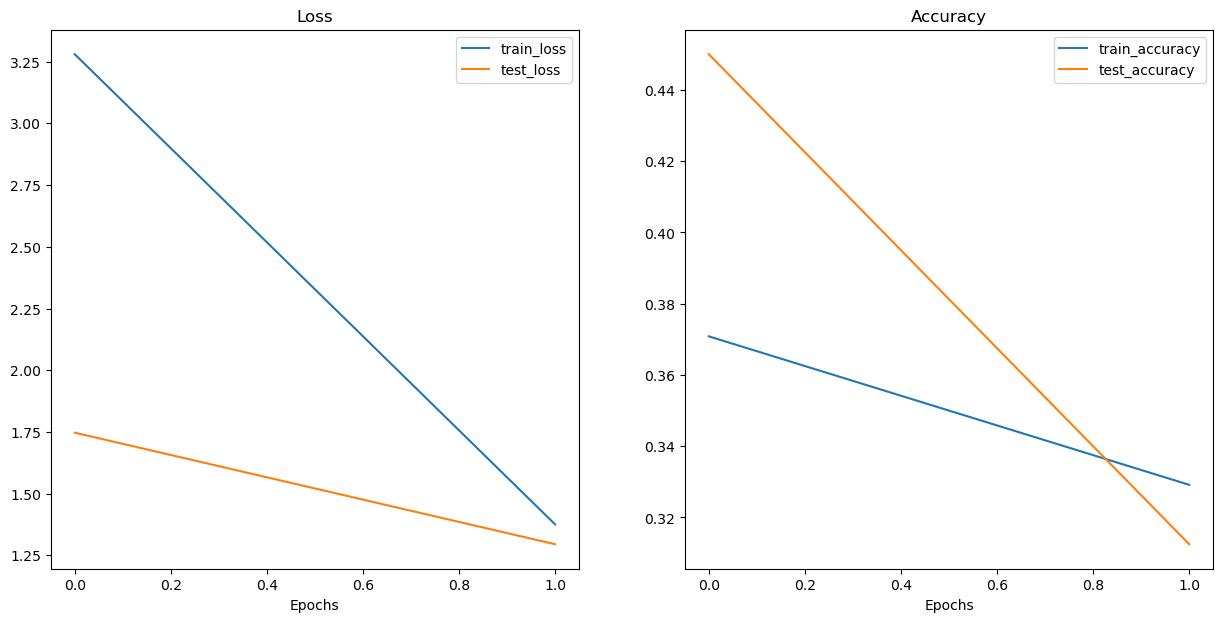

In [120]:
# Plot our ViT model's loss curves
plot_loss_curves(results)


Reading the ViT paper section 4.2:

> Finally, the ViT-L/16 model pre-trained on the public ImageNet-21k dataset performs well on most datasets too, while taking fewer resources to pre-train: it could be trained using a standard cloud TPUv3 with 8 cores in approximately **30 days**.

As of July 2022, the [price for renting a TPUv3](https://cloud.google.com/tpu/pricing) (Tensor Processing Unit version 3) with 8 cores on Google Cloud is $8 USD per hour. 

To rent one for 30 straight days would cost **$5,760 USD**.

adjusting this to oct 7 2023 at $ \$2.20$ per hour gives us $\$1584$ which is a reasonable estimate for the same size GPT2-small that I want to make. not sure what an A100 or H100 would be

### Getting a pretrained ViT model and creating a feature extractor

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torchvision import transforms
from torchinfo import summary
from going_modular.going_modular import data_setup, engine
from helper_functions import download_data, plot_loss_curves
from pathlib import Path

In [ ]:
# set model to MPS if available, or GPU, otherwise default to CPU
if torch.backends.mps.is_available():
    device = "mps"
    print ("MPS device found.")
elif torch.cuda.is_available():
    device = "cuda"
    print("GPU found")
else:
    device = "cpu"
    print ("Neither MPS device nor GPU found.")
    
device = "cpu"

In [ ]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

In [10]:
# 4. Change the classifier head 
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output 

In [11]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit, 
        input_size=(16, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=18,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape        Output Shape       Param #            Trainable
VisionTransformer (VisionTransformer)                        [16, 3, 224, 224]  [16, 3]            768                Partial
├─Conv2d (conv_proj)                                         [16, 3, 224, 224]  [16, 768, 14, 14]  (590,592)          False
├─Encoder (encoder)                                          [16, 197, 768]     [16, 197, 768]     151,296            False
│    └─Dropout (dropout)                                     [16, 197, 768]     [16, 197, 768]     --                 --
│    └─Sequential (layers)                                   [16, 197, 768]     [16, 197, 768]     --                 False
│    │    └─EncoderBlock (encoder_layer_0)                   [16, 197, 768]     [16, 197, 768]     (7,087,872)        False
│    │    └─EncoderBlock (encoder_layer_1)                   [16, 197, 768]     [16, 197, 768]     (7,087,872)        False
│    

In [12]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [13]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=16) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


In [14]:
# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), 
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

In [15]:
# Train the classifier head of the pretrained ViT feature extractor model
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6493 | train_acc: 0.7917 | test_loss: 0.3043 | test_acc: 0.9136
Epoch: 2 | train_loss: 0.2156 | train_acc: 0.9667 | test_loss: 0.1986 | test_acc: 0.9318
Epoch: 3 | train_loss: 0.1404 | train_acc: 0.9708 | test_loss: 0.1889 | test_acc: 0.9318
Epoch: 4 | train_loss: 0.1081 | train_acc: 0.9833 | test_loss: 0.1842 | test_acc: 0.9318
Epoch: 5 | train_loss: 0.0863 | train_acc: 0.9875 | test_loss: 0.1817 | test_acc: 0.9318
Epoch: 6 | train_loss: 0.0713 | train_acc: 0.9875 | test_loss: 0.1792 | test_acc: 0.9318
Epoch: 7 | train_loss: 0.0619 | train_acc: 0.9875 | test_loss: 0.1789 | test_acc: 0.9318
Epoch: 8 | train_loss: 0.0500 | train_acc: 0.9958 | test_loss: 0.1824 | test_acc: 0.9318
Epoch: 9 | train_loss: 0.0433 | train_acc: 0.9958 | test_loss: 0.1803 | test_acc: 0.9318
Epoch: 10 | train_loss: 0.0403 | train_acc: 0.9958 | test_loss: 0.1799 | test_acc: 0.9318


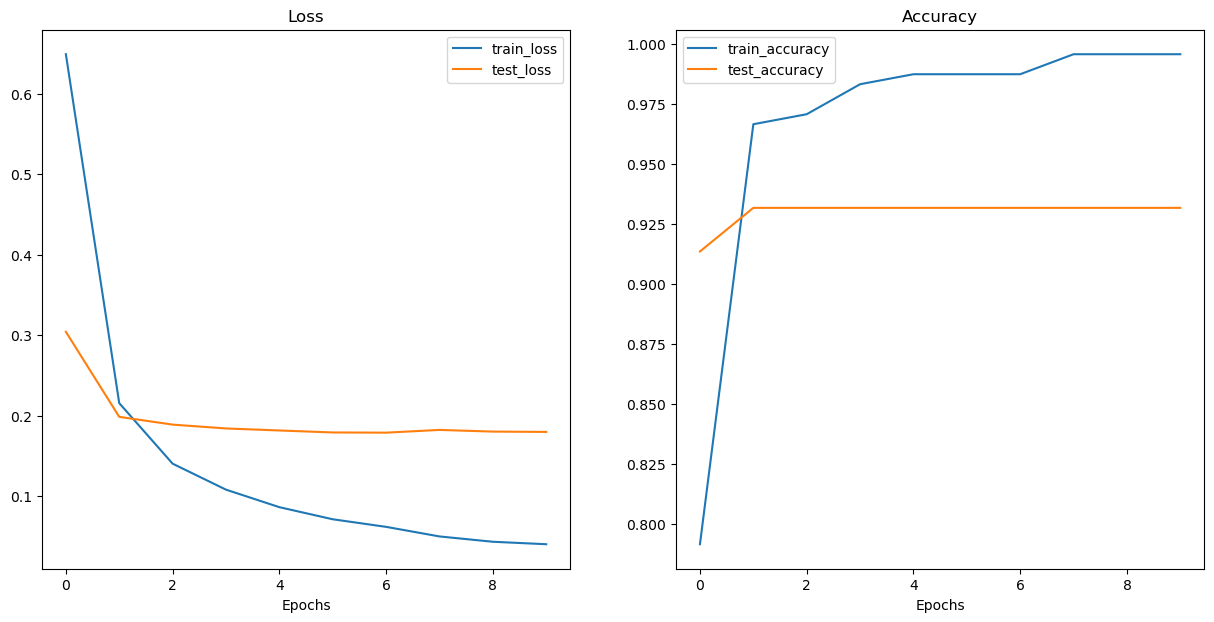

In [16]:
plot_loss_curves(pretrained_vit_results) 

In [17]:
from going_modular.going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [18]:
# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly) 
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


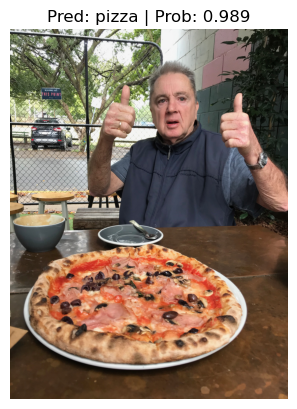

In [20]:
import requests

# Import function to make predictions on images and plot them 
from going_modular.going_modular.predictions import pred_and_plot_image

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path="/Users/tunadorable/Local_Repositories/pytorch-deep-learning/my-notes/data/04-pizza-dad.jpeg",
                    class_names=class_names)